# 1. Limpieza de Datos

In [209]:
import pandas as pd

In [210]:
df_trabajos = pd.read_csv('../datasets/trabajos.csv')
df_trabajo_empleados = pd.read_csv('../datasets/trabajo_empleados.csv')

In [211]:
df_prediccion = df_trabajos[['id', 'tipo_trabajo', 'prioridad']].copy()
df_prediccion.rename(columns={'id': 'trabajo_id'}, inplace=True)

In [212]:
empleados_por_trabajo = (
    df_trabajo_empleados
    .groupby('trabajo_id', as_index=False)['empleado_id']
    .count()
    .rename(columns={'empleado_id': 'cantidad_empleados'})
)

In [213]:
df_prediccion = df_prediccion.merge(
    empleados_por_trabajo,
    on='trabajo_id',
    how='left'
)

In [214]:
df_prediccion

,trabajo_id,tipo_trabajo,prioridad,cantidad_empleados
0,1,reparacion,urgente,5
1,2,instalacion,baja,5
2,3,mantenimiento,normal,4
3,4,instalacion,normal,3
4,5,mantenimiento,urgente,4
...,...,...,...,...
2017,2018,mantenimiento,normal,3
2018,2019,configuracion,alta,5
2019,2020,instalacion,normal,4
2020,2021,configuracion,alta,5


In [215]:
df_prediccion['cantidad_empleados'] = df_prediccion['cantidad_empleados'].fillna(0).astype(int)

In [216]:
# Convertir fechas y calcular el tiempo de resolución en horas
df_trabajos['created_at'] = pd.to_datetime(df_trabajos['created_at'], errors='coerce')
df_trabajos['updated_at'] = pd.to_datetime(df_trabajos['updated_at'], errors='coerce')
df_prediccion['tiempo_resolucion'] = (df_trabajos['updated_at'] - df_trabajos['created_at']).dt.total_seconds() / 3600

In [217]:
tiempo_validacion = [
    # Reglas para 'configuracion'
    {'tipo_trabajo': 'configuracion', 'prioridad': 'alta', 'empleados_min': 2, 'empleado_max': 5, 'tiempo_min': 45, 'tiempo_maximo': 240},
    {'tipo_trabajo': 'configuracion', 'prioridad': 'baja', 'empleados_min': 2, 'empleado_max': 2, 'tiempo_min': 30, 'tiempo_maximo': 180},
    {'tipo_trabajo': 'configuracion', 'prioridad': 'normal', 'empleados_min': 2, 'empleado_max': 3, 'tiempo_min': 40, 'tiempo_maximo': 150},
    {'tipo_trabajo': 'configuracion', 'prioridad': 'urgente', 'empleados_min': 2, 'empleado_max': 5, 'tiempo_min': 30, 'tiempo_maximo': 240},

    # Reglas para 'instalacion'
    {'tipo_trabajo': 'instalacion', 'prioridad': 'alta', 'empleados_min': 1, 'empleado_max': 3, 'tiempo_min': 60, 'tiempo_maximo': 360},
    {'tipo_trabajo': 'instalacion', 'prioridad': 'baja', 'empleados_min': 1, 'empleado_max': 2, 'tiempo_min': 45, 'tiempo_maximo': 240},
    {'tipo_trabajo': 'instalacion', 'prioridad': 'normal', 'empleados_min': 1, 'empleado_max': 2, 'tiempo_min': 50, 'tiempo_maximo': 300},
    {'tipo_trabajo': 'instalacion', 'prioridad': 'urgente', 'empleados_min': 1, 'empleado_max': 3, 'tiempo_min': 40, 'tiempo_maximo': 360},

    # Reglas para 'mantenimiento'
    {'tipo_trabajo': 'mantenimiento', 'prioridad': 'alta', 'empleados_min': 1, 'empleado_max': 2, 'tiempo_min': 30, 'tiempo_maximo': 180},
    {'tipo_trabajo': 'mantenimiento', 'prioridad': 'baja', 'empleados_min': 1, 'empleado_max': 1, 'tiempo_min': 20, 'tiempo_maximo': 120},
    {'tipo_trabajo': 'mantenimiento', 'prioridad': 'normal', 'empleados_min': 1, 'empleado_max': 1, 'tiempo_min': 25, 'tiempo_maximo': 150},
    {'tipo_trabajo': 'mantenimiento', 'prioridad': 'urgente', 'empleados_min': 1, 'empleado_max': 2, 'tiempo_min': 20, 'tiempo_maximo': 180},

    # Reglas para 'reparacion'
    {'tipo_trabajo': 'reparacion', 'prioridad': 'alta', 'empleados_min': 1, 'empleado_max': 3, 'tiempo_min': 90, 'tiempo_maximo': 480},
    {'tipo_trabajo': 'reparacion', 'prioridad': 'baja', 'empleados_min': 1, 'empleado_max': 2, 'tiempo_min': 60, 'tiempo_maximo': 360},
    {'tipo_trabajo': 'reparacion', 'prioridad': 'normal', 'empleados_min': 1, 'empleado_max': 2, 'tiempo_min': 75, 'tiempo_maximo': 420},
    {'tipo_trabajo': 'reparacion', 'prioridad': 'urgente', 'empleados_min': 1, 'empleado_max': 3, 'tiempo_min': 60, 'tiempo_maximo': 480},
]
df_reglas = pd.DataFrame(tiempo_validacion)

In [218]:
def validar_y_ajustar_tiempo(row):
    tipo_trabajo = row['tipo_trabajo']
    prioridad = row['prioridad']
    tiempo_resolucion = row['tiempo_resolucion'] # Ya está en minutos

    # Buscar la regla correspondiente
    regla = df_reglas[(df_reglas['tipo_trabajo'] == tipo_trabajo) & (df_reglas['prioridad'] == prioridad)]

    if not regla.empty:
        tiempo_min = regla['tiempo_min'].iloc[0]
        tiempo_maximo = regla['tiempo_maximo'].iloc[0]

        # No es necesaria la conversión a horas aquí, ya estamos en minutos
        if not (tiempo_min <= tiempo_resolucion <= tiempo_maximo):
            # Si el tiempo está fuera del rango, ajustarlo
            tiempo_ajustado = (tiempo_min + tiempo_maximo) / 2
            #print(f"Advertencia: Tiempo de resolución para '{tipo_trabajo}' con prioridad '{prioridad}' ({tiempo_resolucion:.2f} minutos) fuera de rango. Ajustado a {tiempo_ajustado:.2f} minutos (rango: {tiempo_min:.2f}-{tiempo_maximo:.2f} minutos).")
            return tiempo_ajustado
        else:
            return tiempo_resolucion
    else:
        # Si no se encuentra una regla, se puede mantener el tiempo original
        print(f"Advertencia: No se encontró regla para '{tipo_trabajo}' con prioridad '{prioridad}'.")
        return tiempo_resolucion

In [219]:
df_prediccion['tiempo_resolucion_validado'] = df_prediccion.apply(validar_y_ajustar_tiempo, axis=1)

print("\nDataFrame con tiempos de resolución validados y ajustados:")
df_prediccion


DataFrame con tiempos de resolución validados y ajustados:


,trabajo_id,tipo_trabajo,prioridad,cantidad_empleados,tiempo_resolucion,tiempo_resolucion_validado
0,1,reparacion,urgente,5,39.0,270.0
1,2,instalacion,baja,5,71.0,71.0
2,3,mantenimiento,normal,4,5.0,87.5
3,4,instalacion,normal,3,23.0,175.0
4,5,mantenimiento,urgente,4,3.0,100.0
...,...,...,...,...,...,...
2017,2018,mantenimiento,normal,3,58.0,58.0
2018,2019,configuracion,alta,5,40.0,142.5
2019,2020,instalacion,normal,4,49.0,175.0
2020,2021,configuracion,alta,5,58.0,58.0


In [220]:
# Eliminar la columna 'tiempo_resolucion' si existe
if 'tiempo_resolucion' in df_prediccion.columns:
    df_prediccion.drop(columns='tiempo_resolucion', inplace=True)

# Renombrar la columna 'tiempo_resolucion_validado' a 'tiempo_resolucion'
if 'tiempo_resolucion_validado' in df_prediccion.columns:
    df_prediccion.rename(columns={'tiempo_resolucion_validado': 'tiempo_resolucion'}, inplace=True)

# Contar cuántas veces aparece cada tipo de trabajo y prioridad
df_prediccion['cant_tipo_trabajo'] = df_prediccion['tipo_trabajo'].map(df_prediccion['tipo_trabajo'].value_counts())
df_prediccion['cant_prioridad'] = df_prediccion['prioridad'].map(df_prediccion['prioridad'].value_counts())

In [221]:
df_prediccion

,trabajo_id,tipo_trabajo,prioridad,cantidad_empleados,tiempo_resolucion,cant_tipo_trabajo,cant_prioridad
0,1,reparacion,urgente,5,270.0,492,520
1,2,instalacion,baja,5,71.0,487,253
2,3,mantenimiento,normal,4,87.5,499,507
3,4,instalacion,normal,3,175.0,487,507
4,5,mantenimiento,urgente,4,100.0,499,520
...,...,...,...,...,...,...,...
2017,2018,mantenimiento,normal,3,58.0,499,507
2018,2019,configuracion,alta,5,142.5,544,742
2019,2020,instalacion,normal,4,175.0,487,507
2020,2021,configuracion,alta,5,58.0,544,742


# Analizis y visualizacion

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

In [223]:
# Estilo de los gráficos
sns.set(style="whitegrid")

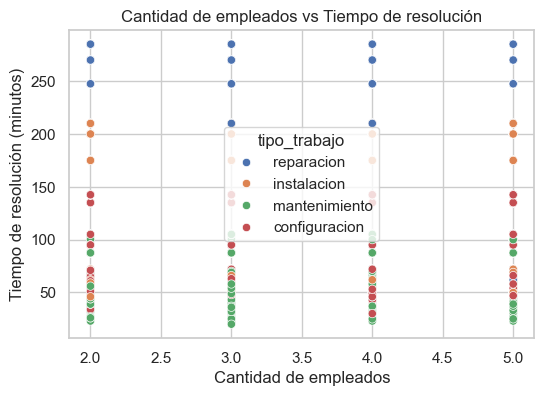

In [225]:
# 1. cantidad_empleados vs tiempo_resolucion
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_prediccion, x='cantidad_empleados', y='tiempo_resolucion', hue='tipo_trabajo')
plt.title('Cantidad de empleados vs Tiempo de resolución')
plt.xlabel('Cantidad de empleados')
plt.ylabel('Tiempo de resolución (minutos)')
plt.show()

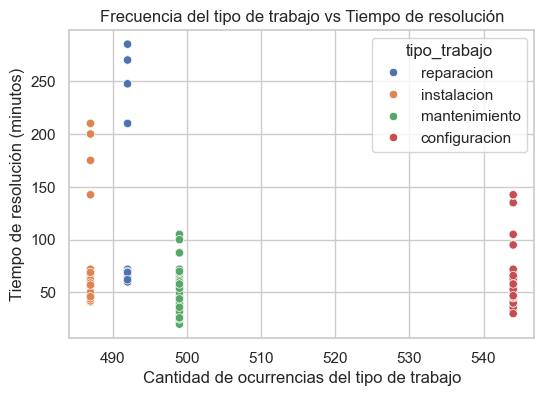

In [226]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_prediccion, x='cant_tipo_trabajo', y='tiempo_resolucion', hue='tipo_trabajo')
plt.title('Frecuencia del tipo de trabajo vs Tiempo de resolución')
plt.xlabel('Cantidad de ocurrencias del tipo de trabajo')
plt.ylabel('Tiempo de resolución (minutos)')
plt.show()

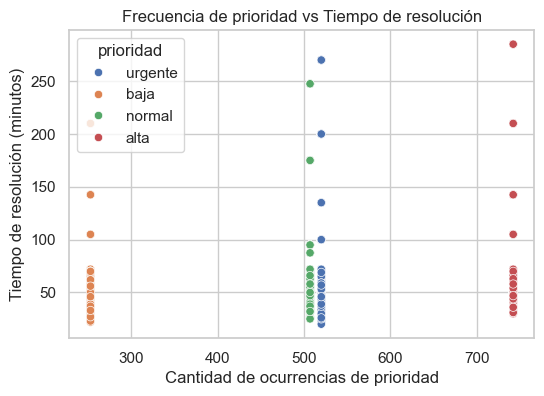

In [227]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_prediccion, x='cant_prioridad', y='tiempo_resolucion', hue='prioridad')
plt.title('Frecuencia de prioridad vs Tiempo de resolución')
plt.xlabel('Cantidad de ocurrencias de prioridad')
plt.ylabel('Tiempo de resolución (minutos)')
plt.show()

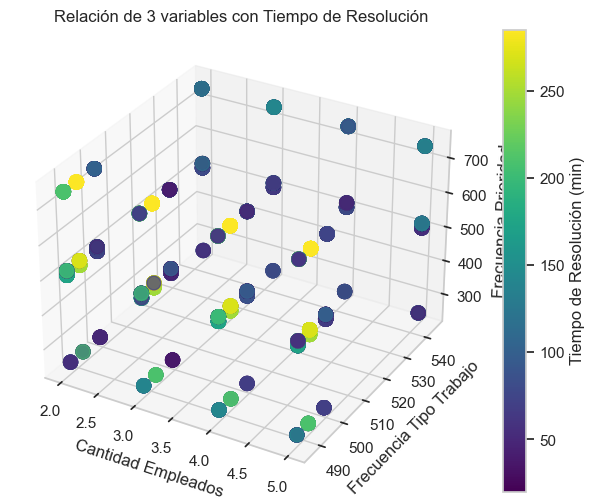

In [228]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x = df_prediccion['cantidad_empleados']
y = df_prediccion['cant_tipo_trabajo']
z = df_prediccion['cant_prioridad']
c = df_prediccion['tiempo_resolucion']

# Usamos el tiempo como color
sc = ax.scatter(x, y, z, c=c, cmap='viridis', s=100)

ax.set_xlabel('Cantidad Empleados')
ax.set_ylabel('Frecuencia Tipo Trabajo')
ax.set_zlabel('Frecuencia Prioridad')
plt.title('Relación de 3 variables con Tiempo de Resolución')

# Barra de color
cb = plt.colorbar(sc)
cb.set_label('Tiempo de Resolución (min)')

plt.show()


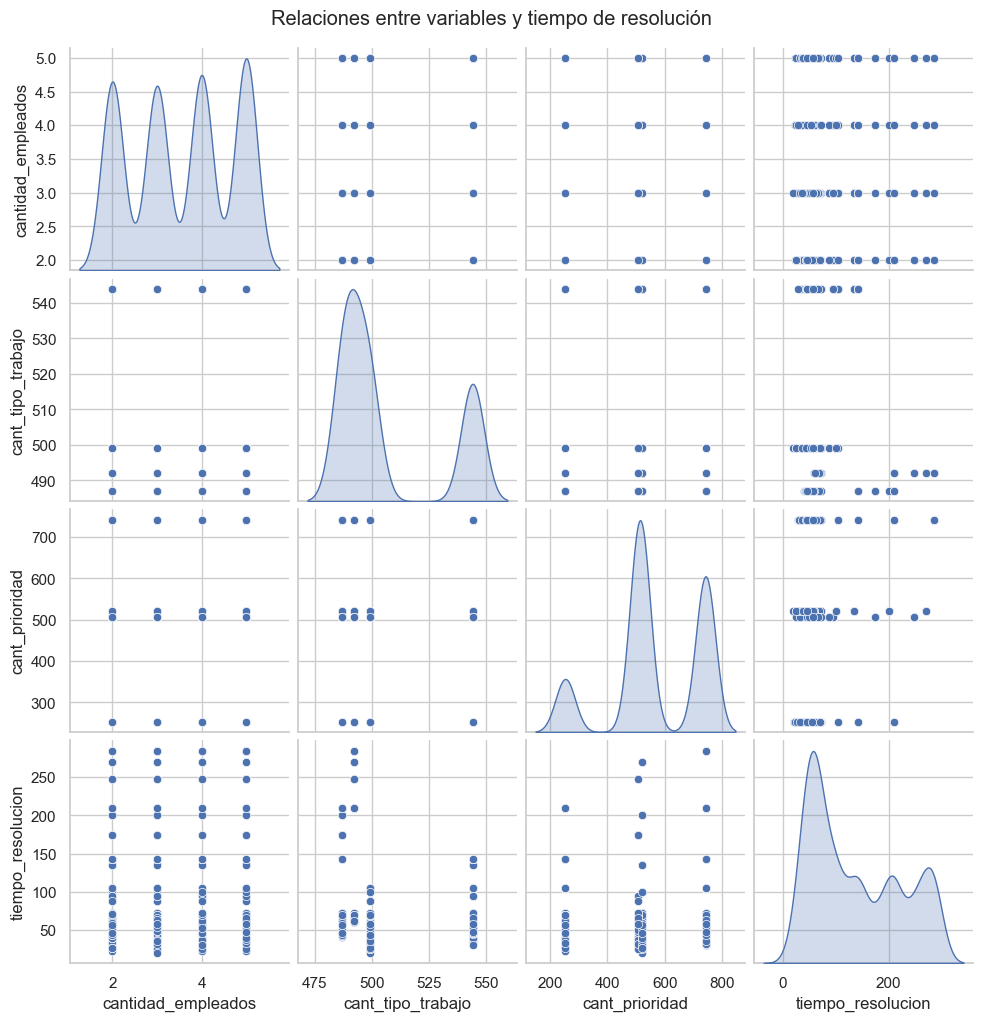

In [229]:
import seaborn as sns

sns.pairplot(df_prediccion, vars=[
    'cantidad_empleados',
    'cant_tipo_trabajo',
    'cant_prioridad',
    'tiempo_resolucion'
], kind='scatter', diag_kind='kde')

plt.suptitle('Relaciones entre variables y tiempo de resolución', y=1.02)
plt.show()


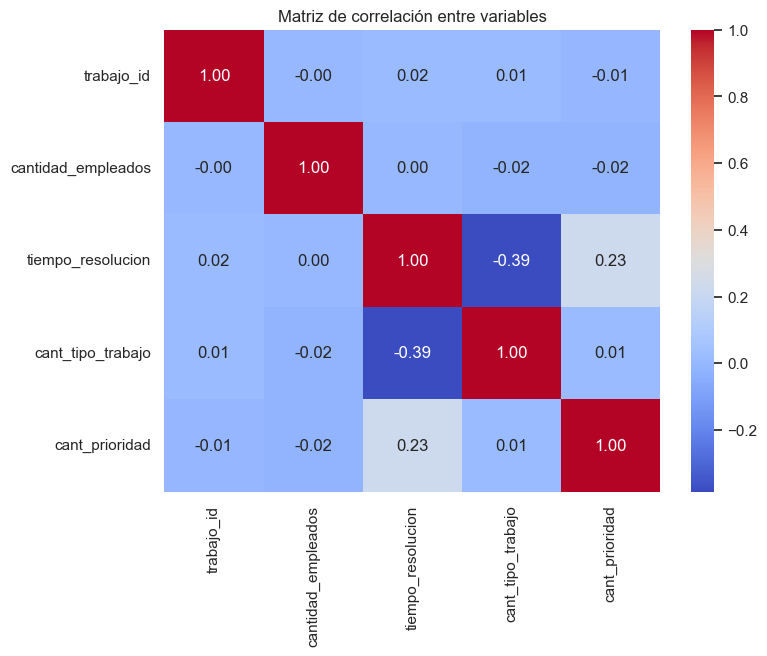

In [230]:
import seaborn as sns
import numpy as np

correlation_matrix = df_prediccion.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre variables')
plt.show()

# Regresion Lineal

In [231]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [232]:
X = df_prediccion[['cantidad_empleados', 'cant_tipo_trabajo', 'cant_prioridad']]
y = df_prediccion['tiempo_resolucion']

In [237]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['tipo_trabajo', 'prioridad']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(df_prediccion[cat_cols])

# Combinar con numéricas
X = pd.concat([
    df_prediccion[['cantidad_empleados', 'cant_tipo_trabajo', 'cant_prioridad']],
    pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))
], axis=1)


In [238]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1617, 9), (1617,), (405, 9), (405,))

In [239]:
# Crear y entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [241]:
# Hacer predicciones
y_pred = modelo.predict(X_test)

# Evaluar
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R²):", r2)

Coeficientes: [ -1.12354052  -1.26126527   0.12715118 -15.12551724 -85.4840339
  90.5807168    3.22360765  -1.93874687  -5.04894494]
Intercepto: 713.1259092623832
Error cuadrático medio (MSE): 1988.6471300019155
Coeficiente de determinación (R²): 0.7257534531729176


In [242]:
# Mostrar nombres de columnas y sus coeficientes
for col, coef in zip(X.columns, modelo.coef_):
    print(f'{col}: {coef:.2f}')

cantidad_empleados: -1.12
cant_tipo_trabajo: -1.26
cant_prioridad: 0.13
tipo_trabajo_instalacion: -15.13
tipo_trabajo_mantenimiento: -85.48
tipo_trabajo_reparacion: 90.58
prioridad_baja: 3.22
prioridad_normal: -1.94
prioridad_urgente: -5.05


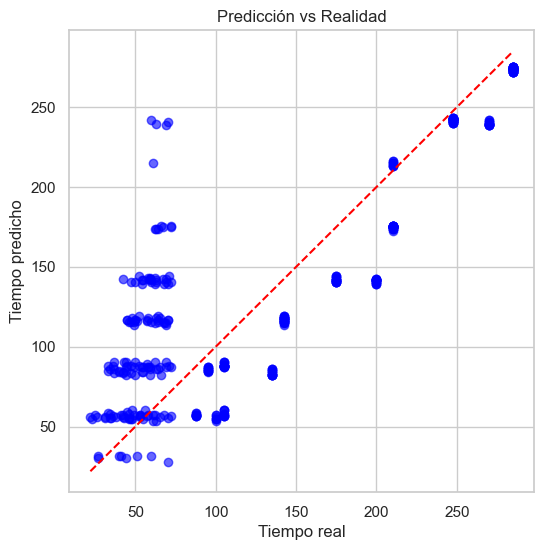

In [243]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Tiempo real')
plt.ylabel('Tiempo predicho')
plt.title('Predicción vs Realidad')
plt.grid(True)
plt.show()

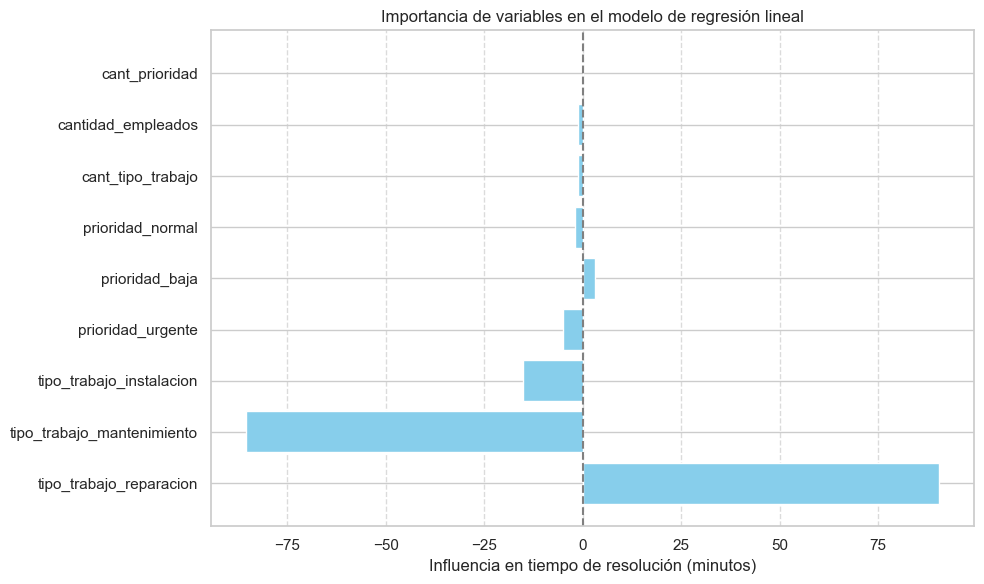

In [244]:
import matplotlib.pyplot as plt

# Coeficientes y nombres de las columnas
coeficientes = modelo.coef_
nombres_columnas = X.columns

# Crear DataFrame para facilitar ordenamiento y visualización
importancia = pd.DataFrame({
    'variable': nombres_columnas,
    'coeficiente': coeficientes
}).sort_values(by='coeficiente', key=abs, ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancia['variable'], importancia['coeficiente'], color='skyblue')
plt.axvline(0, color='gray', linestyle='--')  # Línea vertical en x=0
plt.xlabel('Influencia en tiempo de resolución (minutos)')
plt.title('Importancia de variables en el modelo de regresión lineal')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# probar ML

In [246]:
import pandas as pd

# Paso 1: Crear el nuevo dato
nuevo = pd.DataFrame([{
    'cantidad_empleados': 4,
    'cant_tipo_trabajo': 490,
    'cant_prioridad': 500,
    'tipo_trabajo': 'reparacion',
    'prioridad': 'urgente'
}])

# Paso 2: Codificar las variables categóricas igual que en el entrenamiento
nuevo_encoded = encoder.transform(nuevo[['tipo_trabajo', 'prioridad']])
nuevo_encoded_df = pd.DataFrame(
    nuevo_encoded,
    columns=encoder.get_feature_names_out(['tipo_trabajo', 'prioridad'])
)

# Paso 3: Unir con variables numéricas
nuevo_final = pd.concat([
    nuevo[['cantidad_empleados', 'cant_tipo_trabajo', 'cant_prioridad']].reset_index(drop=True),
    nuevo_encoded_df.reset_index(drop=True)
], axis=1)

# Paso 4: Predecir
prediccion = modelo.predict(nuevo_final)
print(f"⏱ Tiempo de resolución estimado: {prediccion[0]:.2f} minutos")

⏱ Tiempo de resolución estimado: 239.72 minutos


# guardar ML

In [247]:
import joblib

# Guardar el modelo entrenado y el encoder
joblib.dump(modelo, 'modelo_regresion.pkl')
joblib.dump(encoder, 'encoder_categorias.pkl')

['encoder_categorias.pkl']

In [ ]:
modelo = joblib.load('modelo_regresion.pkl')
encoder = joblib.load('encoder_categorias.pkl')